# NLTK 


NLTK or Natural Language Toolkit is the *de-facto* standard python module for building and running natural language processing applications in the language.

It consists of a collection of widely used datasets and algorithms for language processing applications such as tokenizers, part-of-speech taggers, stopword sets, standard text sets and trainable machine-learning algorithms.

Using the toolkit requires a reasonable working knowledge of Python which hopefully by studying the [preceeding exercises](https://brainsteam.co.uk/wiki/public:phd:teaching:cs918) you will have by now.

In this exercise we will use a number of the skills we have already examined to do some analysis on the [ART corpus](https://www.aber.ac.uk/en/cs/research/cb/projects/art/art-corpus/).

## About the dataset

If you have been through the XML exercise then you will already have been briefly introduced to the corpus. It consists of 225 biochemistry papers that have been broken up into individual sentences.

Each sentence has also been annotated with a label that describes the core scientific concept (CoreSC) that the sentence encapsulates.

For example, a sentence might be labelled "Motivation" if it explains why the author is carrying out a particular study or it might be labelled "Hypothesis" if it discusses expected results of a study. You can find out more about the annotation scheme specification [in this paper by Liakata et al. 2010](http://www.lrec-conf.org/proceedings/lrec2010/pdf/644_Paper.pdf).

## What can we find out?

Let's play with the data! We know that a particular sentence has a particular label. From this, can we make any assumptions about the words in the sentences? Are there some words that occur more frequently in some types of sentences?

Let's find out...

## Preparing the data

The first thing we need to do is extract a list of sentences and their respective CoreSC label. I have downloaded the ART corpus `tar.gz` file and placed it in the assets folder in this project. The following code iterates over the contained folders, finding all XML files and parsing them.

First we import requisite libraries...

In [1]:
import nltk
import os #we haven't used this one before. Check out the docs https://docs.python.org/3/library/os.html
from multiprocessing import Pool # we will be using this to speed up some of the longer processing loops
import xml.etree.ElementTree as ET

We define a function for parsing the paper, extracting sentences and returning a list of tuples (sentence text,label)


In [2]:
def extract_paper(filename):
    
    #open and parse the paper
    tree = ET.parse(filename)
    root = tree.getroot()
    
    sents = []
    
    #iterate through sentences
    for sent in root.iter("s"):
        annoArt = sent.find('annotationART')
        id = sent.get("sid")
        text = "".join(annoArt.itertext())
        coreSC = annoArt.get("type")
        sents.append( (filename, id, text,coreSC) )
    
    return sents


We iterate through all papers in the ART corpus using [`os.walk`](https://docs.python.org/3/library/os.html#os.walk) which recursively steps through all files and subdirectories in a given directory, allowing you to process any file of interest.

In [3]:
art_path = "assets/ART_Corpus"

all_sents = []

filecount = 0

# this layer of the for loop iterates through each subdirectory of the given path
# producing a list of directories and files in that immediate directory.
# root represents the (sub)directory currently being inspected
for root, dirs, files in os.walk(art_path):
    
    #we loop through the list of files in the current subdirectory
    for file in files:
        
        if file.endswith(".xml"):
            filecount += 1
            #we use os.path.join to concatenate the directory name and file name safely
            #with respect to slashes in the path
            fullpath = os.path.join(root,file)
            
            #we parse the file and keep the sentences
            all_sents += extract_paper(fullpath)
            
#lets get a total count of sentences collected and files examined
print("Inspected {} files".format(filecount))
print ("Collected {} sentences".format(len(all_sents)))


Inspected 225 files
Collected 34680 sentences


As a sanity check, let's inspect 5 sentences in the array and make sure that they are of the format (filename, id, some text, coresc). We use the standard library module [`random`](https://docs.python.org/3.0/library/random.html) to pick 5 from the list at random. 

In [4]:
import random

randsents = random.sample(all_sents,5)

for senttuple in randsents:
    print (senttuple)

('assets/ART_Corpus/ann2/b401234h_mode2.xml', '68', 'For example, when V ≠ 0 eqn. (14) implies ∂\ue0cd/∂x ≠ 0 at all x ≠ L, so that a steady-state current flows in the system.', 'Met')
('assets/ART_Corpus/ann6/b316053j_mode2.xml', '19', 'A high repetition rate is also required for multiple photon absorption leading to dissociation during ion trapping times.', 'Bac')
('assets/ART_Corpus/ann7/b407500e_mode2.xml', '76', 'We rationalized these findings by positing a switch in the mode of proton and electron transfer at the S2 stage of the cycle, a change activated by the positive charge developed on the OEC in the S1 → S2 transition.10', 'Bac')
('assets/ART_Corpus/ann4/b312242e_mode2.xml', '122', 'Comparison of Table 5 with Table 6 (which contains analogous data for the systems restricted to 90°) reveals that in all cases the relaxation of the 90° restriction produces larger P1–M1–M2–P2, significantly bigger interaction energies and, in almost all cases, smaller r(M–M).', 'Res')
('assets/A

This looks right. Out of curiosity, lets see how many of each CoreSC type there are and plot a Pie chart using matplotlib.


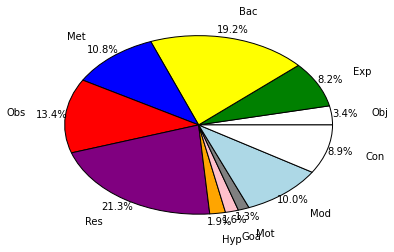

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

#read about the counter object on the 
#collections doc page (https://docs.python.org/3/library/collections.html#collections.Counter)
from collections import Counter 

lbl_tally = Counter([ lbl for file, id, text, lbl in all_sents])

total = len(all_sents)

percentages = { x: (lbl_tally[x] / total * 100) for x in lbl_tally }

labels = [ x for x in percentages.keys() ]
values = [ percentages[x] for x in labels]

plt.pie(values, 
        labels=labels, 
        labeldistance=1.3,
        autopct="%1.1f%%", 
        pctdistance=1.1,
        colors=["white","green","yellow","blue","red", "purple", "orange","pink","grey","lightblue"])
plt.show()

So we see that there is quite a lot of variation in the types of sentences and their respective representation within the corpus. Results takes up around a fifth of the total number of sentences and hypothesis a measly 1.9%.

We need to remember this in our experiments - all CoreSCs are not born equal - some are more likely to occur than others.

## Word distributions

Let's look at which words are most likely to occur in different sentence types. We build a dictionary of words by parsing and tokenizing every single sentence in our collection. We store a record of each word's occurence in each CoreSC so that we can build a frequency distribution table later. We will depend upon NLTK heavily for this work.

### Tokenizing sentences
First we use `nltk.word_tokenize` to break down each sentence into a series of "words" and build a dictionary. Then we examine the top 10 words.

In [6]:
dictionary = Counter()

for file, id, text, lbl in all_sents:
    
    words = nltk.word_tokenize(text)
    dictionary.update(words)
    
print(dictionary.most_common(10))

[('the', 68837), (',', 39491), ('of', 37264), ('.', 35687), ('and', 22079), (')', 20407), ('(', 20394), ('in', 18974), ('to', 17391), ('a', 14400)]


### Filtering out common words

Unsurprisingly, the most common word is 'the' and second most common is 'of'. In fact there really aren't any surprises. 

In natural language processing, these are what we call "stopwords" and they are typically filtered out before we do anything interesting with the data to remove excess noise. After all, we already know that 'the' etc are common words - we aren't interested in this.

NLTK comes, by default, with a set of stopwords we can use to filter on. It does not incorporate punctutation so we manually append '.' and ',' to the stopwords list. We also append 'Fig' to the stoplist since this is commonly used throughout many of the papers to represent "figure" as in "look at Fig 1 to see..."

In [7]:
from nltk.corpus import stopwords as stopwordloader

stopwords = stopwordloader.words()

stopwords.extend(['.',',',')','(',':','+','=','fig'])

print ("There are {} stopwords".format(len(stopwords)))

There are 2439 stopwords


This modified next step could take a bit longer because Python now has to run a filter operation on every single word.

In [9]:
dictionary = Counter()

p = Pool()

def wordcount(sentence):
    
    wc = Counter()
    
    file, id, text, lbl = sentence
    
    words = [ word for word in nltk.word_tokenize(text) if word.lower() not in stopwords ]
    wc.update(words)
    
    return wc, lbl
 
for wc, lbl in p.map(wordcount, all_sents):
    dictionary.update(wc)
    
print(dictionary.most_common(10))

[('1', 2664), ('energy', 2323), ('two', 1988), ('2', 1962), ('state', 1588), ('using', 1543), ('surface', 1505), ('used', 1472), ('observed', 1402), ('reaction', 1391)]


This is much more interesting, we can see that the top words all look much more relevent to the biochemistry domain and there are no longer any punctuation marks in the list.

Now we attempt to capture the most common words in each separate CoreSC. We initialise counters for each CoreSC label.


In [11]:
counters = { x: Counter() for x in set([lbl for file, id, text, lbl in all_sents]) }

p = Pool()
 
for wc, lbl in p.map(wordcount, all_sents):
    counters[lbl].update(wc)
    
for lbl in counters:
    print("Top 5 words for {}".format(lbl))
    print(counters[lbl].most_common(5))

Top 5 words for Bac
[('state', 402), ('energy', 401), ('two', 361), ('structure', 329), ('reaction', 310)]
Top 5 words for Hyp
[('may', 91), ('expected', 88), ('would', 78), ('state', 52), ('energy', 46)]
Top 5 words for Obs
[('1', 601), ('2', 501), ('shown', 433), ('Table', 403), ('shows', 373)]
Top 5 words for Met
[('used', 352), ('using', 345), ('1', 243), ('energy', 233), ('method', 188)]
Top 5 words for Res
[('1', 558), ('energy', 548), ('two', 507), ('2', 485), ('observed', 484)]
Top 5 words for Mod
[('1', 421), ('energy', 398), ('eqn', 370), ('[', 319), (']', 316)]
Top 5 words for Mot
[('important', 39), ('interest', 37), ('reaction', 32), ('studies', 30), ('molecular', 28)]
Top 5 words for Goa
[('order', 59), ('study', 58), ('using', 57), ('present', 52), ('work', 46)]
Top 5 words for Obj
[('using', 99), ('study', 91), ('two', 81), ('present', 81), ('results', 79)]
Top 5 words for Exp
[('1', 360), ('%', 354), ('using', 333), ('used', 300), ('laser', 242)]
Top 5 words for Con
[(

### TD/IDF

You can see that there is a lot of crossover for some of these words - 'droplet' appears in the top 5 for 8 of the 10 CoreSC concepts represented in the ART corpus. What would be more interesting is a list of the top words that appear in a CoreSC **and** that are mostly distinct to that CoreSC.

Here we use a measurement called Term Frequency-Intra-Document Frequency (TF-IDF). The Term Frequency (TF) is the number of times a term appears in the document (or CoreSC) you are inspecting. The Intra-Document Frequency (IDF) is the specivity of the term or word. By multiplying TF by IDF we identify how 'unique' the term is to the document under scrutiny. 

A high TF-IDF suggests that the word or term is very relevent to the current document. A low TF-IDF suggests that the word is common across the whole corpus. 

Here we use this principle to identify which words in the dictionary are most relevent when working with a specific CoreSC category.

TF is normally just calculated as the frequency of the term within the document you are interested in. However if one document is longer than the rest (or in our case one CoreSC is represented more strongly than another) then words in that class (i.e. words in Background (Bac) will probably have a stronger natural TF than words in Methodology (Met) purely because Background forms 28% of the corpus and Methodology just over 1%. In order to normalise this, we use augmented frequency defined as:

$$ tf(t,d) = 0.5 + 0.5 \frac { f_{t,d} } { max\{ f_{t',d} : t' \in d \}  } $$

We are dividing the raw frequency $f_{t,d}$ by the maximum raw frequency of any term in the CoreSC category.

NB: TF-IDF can also be used to identify and filter out stopwords. However, by removing common stopwords using a list as we did in the steps above, we have reduced the complexity of the calculations pre-emptively and hopefully reduced overall noise.

In [22]:
import math 
from multiprocessing import Pool

tfidfs =  { label : {} for label in counters }

max_ftds = { label : counters[label].most_common(1)[0][1] for label in counters }

def tf(word, coresc):
    global max_ftds
    f_td = max_ftds[coresc]
    return 0.5 + (0.5 * counters[coresc][word] / f_td)

def idf(word):
    N = len(counters) 
    return math.log(N / sum([1 for x in counters if word in counters[x]]) )

idfs = { word: idf(word) for word in dictionary }


In [25]:
import itertools

tfidf = lambda word,coresc: tf(word,coresc) * idfs[word]
    
def mappable_tfidf(word):
    for coresc in counters:
        yield (coresc,word,tfidf(word,coresc))
        
for coresc, word, tfidf_val in itertools.chain(*map(mappable_tfidf, dictionary.keys() )):
    tfidfs[coresc][word] = tfidf_val
    
for coresc in tfidfs:
    topwords = sorted(tfidfs[coresc], key= lambda x: tfidfs[coresc][x], reverse=True)[0:10] 
    topscores = [ (word, tfidfs[coresc][word]) for word in topwords ]
    print ( coresc, topscores )
    print ("------------------------------------")

Con [('δCCSD', 1.2285512817423752), ('μ-O2CR', 1.2186833999613118), ('operando', 1.2186833999613118), ('corroborates', 1.2137494590707802), ('intermittent', 1.2137494590707802), ('H–π', 1.2137494590707802), ('cofacial', 1.2137494590707802), ('Tafel–Volmer', 1.2137494590707802), ('Concluding', 1.2137494590707802), ('CH2NO2', 1.2137494590707802)]
------------------------------------
Bac [('LiAlH4', 1.23175466127578), ('Mo-nitrogenase', 1.2257897476618536), ('catalyzes', 1.2257897476618536), ('cyanobacteria', 1.2228072908548904), ('reviews', 1.2198248340479274), ('TiCl4', 1.2198248340479274), ('FeMo', 1.2198248340479274), ('haem', 1.2198248340479274), ('thylakoid', 1.2198248340479274), ('1985', 1.2198248340479274)]
------------------------------------
Met [('DF/LIF', 1.2159781425980374), ('Mandelshtam', 1.2159781425980374), ('TaqMan®', 1.2159781425980374), ('quantitation', 1.212572041358267), ('isoxazoline', 1.212572041358267), ('citrate-type', 1.212572041358267), ('F0', 1.212572041358267

This is now becoming rather interesting. We can see that the words TF-IDF identifies as most important for each CoreSC seem to fit the CoreSC context quite well.

For example, the most pertinent words in the "Conclusion" class are things like "corroborates", "intermittent" and "concluding" which are words you might expect to find in a conclusion. The "model section" has words like "orbit" and "substituting" which you might expect to find in a definition of a scientific model.

## Classifying text

We can be fairly sure from the above experiment that the words in a sentence are a good indicator as to which CoreSC it belongs to. It logically follows that a sentence containing multiple words with a high TF-IDF for one particular category is likely to belong to that category.

We can try training a machine learning classifier to predict which CoreSC a sentence belongs to.

### Data preparation

We want to train the classifier on a representative set of the sentences available. However we want to avoid showing the classifier all of the data so that we have something to test it with later. Here we will split the data into two subsets: a training set and a testing set. We will use 4/5 of the sentences for training and 1/5 for testing. 

In [58]:
sent_groups = {}
train_sets = {}
test_sets = {}

for file, id, text, lbl in all_sents:
    
    if lbl not in sent_groups:
        sent_groups[lbl] = []
        
    sent_groups[lbl].append((id,text))
    
for lbl in sent_groups:
    print(lbl,len(sent_groups[lbl]))
    
    train_proportion = len(sent_groups[lbl]) * 4 // 5
    
    all_examples = range(len(sent_groups[lbl]))
    
    train_idxs = random.sample(all_examples, train_proportion)
    
    test_idxs = set(all_examples) - set(train_idxs)
    
    train_sets[lbl] = [ sent_groups[lbl][x] for x in train_idxs ]    
    test_sets[lbl] = [ sent_groups[lbl][x] for x in test_idxs ]

    
    print("Training set", len(train_sets[lbl]))
    print("Test set", len(test_sets[lbl]))
    print("------------------")
    
    

Hyp 656
Training set 524
Test set 132
------------------
Bac 6657
Training set 5325
Test set 1332
------------------
Met 3751
Training set 3000
Test set 751
------------------
Obs 4659
Training set 3727
Test set 932
------------------
Goa 548
Training set 438
Test set 110
------------------
Res 7373
Training set 5898
Test set 1475
------------------
Mot 466
Training set 372
Test set 94
------------------
Con 3083
Training set 2466
Test set 617
------------------
Obj 1190
Training set 952
Test set 238
------------------
Mod 3456
Training set 2764
Test set 692
------------------
Exp 2841
Training set 2272
Test set 569
------------------


In [63]:
import itertools

from nltk.classify.util import apply_features

def extract_features(sent):
    id,text = sent
    features = {}
    for word in nltk.word_tokenize(text):
        features['{} in sent'.format(word)] = True
    return features
        
training_sentences = list(itertools.chain(*[ [ (sent,coresc) for sent in sents] for coresc,sents in train_sets.items() ]))

test_sentences =  list(itertools.chain(*[ [ (sent,coresc) for sent in sents] for coresc,sents in test_sets.items() ]))

classifier = nltk.NaiveBayesClassifier.train(apply_features(extract_features, training_sentences,labeled=True) )

print(nltk.classify.accuracy(classifier, apply_features(extract_features, test_sentences,labeled=True)))

classifier.show_most_informative_features(5)

0.343272832036877
Most Informative Features
             may in sent = True              Hyp : Exp    =    203.5 : 1.0
        expected in sent = True              Hyp : Exp    =    189.1 : 1.0
        interest in sent = True              Mot : Obs    =    183.2 : 1.0
              mg in sent = True              Exp : Res    =    115.1 : 1.0
     investigate in sent = True              Goa : Res    =    110.2 : 1.0


So we're immediately able to classify 34.32% of the sentences into the correct CoreSC off the bat. Different CoreSCs are more likely to occur in different locations within a paper. For example most papers start with Background information and end with a conclusion. We next add paper position (based off sentence ID) to see if that improves classification.

In [80]:
import itertools

from nltk.classify.util import apply_features

def extract_features(sent):
    id,text = sent
    features = {}
    features['position_in_paper'] = id
    for word in nltk.word_tokenize(text):
        features['{} in sent'.format(word)] = True
    return features
        
classifier = nltk.NaiveBayesClassifier.train(apply_features(extract_features, training_sentences,labeled=True) )

print(nltk.classify.accuracy(classifier, apply_features(extract_features, test_sentences,labeled=True)))

classifier.show_most_informative_features(10)

0.35767790262172283
Most Informative Features
       position_in_paper = '1'               Obj : Bac    =    436.2 : 1.0
             may in sent = True              Hyp : Exp    =    203.5 : 1.0
        expected in sent = True              Hyp : Exp    =    189.1 : 1.0
        interest in sent = True              Mot : Obs    =    183.2 : 1.0
              mg in sent = True              Exp : Res    =    115.1 : 1.0
     investigate in sent = True              Goa : Res    =    110.2 : 1.0
          should in sent = True              Hyp : Exp    =    110.0 : 1.0
          likely in sent = True              Hyp : Obs    =    101.8 : 1.0
   understanding in sent = True              Mot : Res    =     97.1 : 1.0
      importance in sent = True              Mot : Obs    =     96.6 : 1.0


This has in fact been a slight improvement of around 1.4%. We can visualise the incorrect classifications using a confusion matrix - this is a common way to inspect which classes are being confused most. 



In [84]:
gold = [ lbl for txt, lbl in test_sentences]

test = [ classifier.classify(extract_features(txt)) for txt,lbl in test_sentences  ]

cm = nltk.ConfusionMatrix(gold, test)

print(cm.pretty_format(sort_by_count=True))

    |   R   B   O   M   M   C   E   O   H   G   M |
    |   e   a   b   e   o   o   x   b   y   o   o |
    |   s   c   s   t   d   n   p   j   p   a   t |
----+---------------------------------------------+
Res |<545> 10  97  16  82 233  11   6 279 128  68 |
Bac | 112<157> 15  27  74 147  11  20 250 209 310 |
Obs | 241   3<352> 11  65  50  28   4  88  64  26 |
Met |  34  17  10<115> 99  46  77  17  57 188  91 |
Mod |  32   4  11  18<384> 32  12   7  89  86  17 |
Con |  66   5   5   6  14<216>  2   3 144  71  85 |
Exp |   5   1  12  24  16   .<430>  5  15  50  11 |
Obj |   6   2   1   4  19  13   6 <55>  9  95  28 |
Hyp |   5   .   .   .   5  18   .   . <79>  9  16 |
Goa |   1   .   1   3   3   5   2   4   3 <76> 12 |
Mot |   1   1   .   .   1   5   .   1   7   4 <74>|
----+---------------------------------------------+
(row = reference; col = test)

